## Импорт библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import itertools
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

# Функции для исследования:

In [3]:
def adf_test(series):
    result = adfuller(series)
    print('ADF-statistics: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))

def ARIMA_best(series, maxorder=2, check='AIC'):
    p = d = q = range(0,maxorder)
    pdq = list(itertools.product(p,d,q))
    series_list = []

    for param in pdq:
            model = ARIMA(series, order=param).fit()
            if check == 'AIC':
                series_list.append([param, model.aic])
            elif check == 'BIC':
                series_list.append([param, model.bic])

    df_model = pd.DataFrame(series_list, columns=['param', 'criteria'])
    num = df_model.index[df_model['criteria'] == df_model['criteria'].min()]
    param = df_model['param'].iloc[num].squeeze()

    model = ARIMA(series, order=param).fit()
    print(model.summary().tables[0])
    print(model.summary().tables[1])
    fig = plt.figure(figsize=(14,7.5), dpi=200)
    model.plot_diagnostics(fig=fig, auto_ylims = True)
    plt.savefig('Diagnostics for ARIMA – {}.jpeg'.format(series.name))
    plt.tight_layout()
    plt.show()
    
    return model
    
def SARIMA_best(series, season=12, check='AIC'):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p,d,q))]
    series_list = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            model = SARIMAX(series, order=param, seasonal_order=param_seasonal,
                         enforce_invertibility=False, enforce_stationarity=False).fit(disp=0)
            if check == 'AIC':
                series_list.append([param, param_seasonal, model.aic])
            elif check == 'BIC': 
                series_list.append([param, param_seasonal, model.bic])

    df_model = pd.DataFrame(series_list, columns=['param', 'param_seasonal', 'criteria'])
    num = df_model.index[df_model['criteria'] == df_model['criteria'].min()]
    param, sparam = df_model['param'].iloc[num].squeeze(), df_model['param_seasonal'].iloc[num].squeeze()

    model = SARIMAX(series, order=param, seasonal_order=sparam,
                         enforce_invertibility=False, enforce_stationarity=False).fit(disp=0)
    print(model.summary().tables[0])
    print(model.summary().tables[1])
    fig = plt.figure(figsize=(14,6), dpi=200)
    model.plot_diagnostics(fig=fig, auto_ylims = True)
    plt.savefig('Diagnostics for SARIMA – {}.jpeg'.format(series.name))
    plt.tight_layout()
    plt.show()
    
    return model
    
def check_model_values(model, series, forecast_perc=70, area_perc=40, ci=True):
    num = series.index[series == series.iloc[round(len(series)*forecast_perc/100)]]
    if len(num) > 1:
        num = num[0]
    pred = model.get_prediction(start=num[0], dynamic=False)
    pred_ci = pred.conf_int()
    df_lol = series.shift(1)
    fig, ax = plt.subplots(figsize=(12,4), dpi=200)
    df_lol.plot(ax=ax, c='b')
    pred.predicted_mean.plot(ax=ax, label='Fitted values', c='r', alpha=.7)
    
    if ci == True:
        ax.fill_between(pred_ci.index,
                       pred_ci.iloc[:, 0],
                       pred_ci.iloc[:, 1], color='k', alpha=.1, label='Confidence Interval')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    ax.set_xlim(df_lol.index[round(len(df_lol)*area_perc/100)], 
                df_lol.index[-1])
    ax.set_title('Fitted values vs Real data – {}'.format(ax.get_legend_handles_labels()[1][0]))
    plt.savefig('Checking Model Values – {}.jpeg'.format(ax.get_legend_handles_labels()[1][0]))
    plt.show()
    mape = round(np.mean(abs(model.resid/series)*100),4)
    print('Mean Absolute Percent Error:', mape,'%')
    if mape > 5 and mape < 15:
        print('     That is ± good (> 5% and < 15%)')
    elif mape < 5:
        print('That is good! (< 5%)')
    else:
        print('     Bad! (>1 5%)')
    print('Root Mean Squared Error:', round(np.sqrt(np.mean(model.resid**2)),5))

def forecast(model, series, steps=24, ci=True, dynamic=False):
    pred = model.get_forecast(steps=steps, dynamic=dynamic)
    pred_ci = pred.conf_int()
    series = series.shift(1)
    fig, ax = plt.subplots(figsize=(12,4), dpi=200)
    series.plot(ax=ax, c='b')
    pred.predicted_mean.plot(ax=ax, label='Predicted values', c='purple', alpha=.7)
    
    if ci == True:
       ax.fill_between(pred_ci.index,
                       pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                       color='#9029FD', alpha=.1, label='Confidence Interval')
    
    pred_series = pd.Series(pred.predicted_mean)
    df_forecast = pred.conf_int().join(pd.DataFrame(data=pred_series.values, index=pred.conf_int().index, 
                                                    columns=['predicted values']))
    df_forecast.to_excel('Prediction for {} – CI + predicted values.xlsx'.format(series.name))
    df_forecast.columns=['lower','upper', 'predicted values']    
    for i,j in zip(range(0,5), range(0,5)):
        ax.text(x=series.index[len(series)-1]+dt.timedelta(days=150*i), y=df_forecast['upper'][4*j]+27,
               s=round(df_forecast['upper'][4*j], 1), fontsize=8, 
                bbox=dict(boxstyle='round', facecolor='purple', alpha=0.04))
        ax.text(x=series.index[len(series)-1]+dt.timedelta(days=150*i), y=df_forecast['lower'][4*j]-27,
               s=round(df_forecast['lower'][4*j], 1), fontsize=8,
                bbox=dict(boxstyle='round', facecolor='purple', alpha=0.04))
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc=2)
    ax.set_xlim(series.index[round(len(series)/2)])
    ax.set_title('Forecast – {}'.format(ax.get_legend_handles_labels()[1][0]))
    plt.savefig('Forecast Plot {}.jpeg'.format(ax.get_legend_handles_labels()[1][0]))
    plt.show()
    
def forecast_joint(model1, model2, series1, series2):
    pred1 = model1.get_forecast(steps=24)
    pred_ci1 = pred1.conf_int()
    series1 = series1.shift(1)
    fig, ax = plt.subplots(figsize=(12,4), dpi=200)
    series1.plot(ax=ax, c='orange')
    pred1.predicted_mean.plot(ax=ax, label='Predicted values 1', c='orange', ls='--', alpha=.7)
    
    ax.fill_between(pred_ci1.index,
                    pred_ci1.iloc[:, 0], pred_ci1.iloc[:, 1], 
                    color='#FDB629', alpha=.1, label='Confidence Interval 2')
    
    df_pred1 = pred1.conf_int()
    df_pred1.columns=['lower','upper']    

    pred2 = model2.get_forecast(steps=24)
    pred_ci2 = pred2.conf_int()
    series2 = series2.shift(1)
    
    series2.plot(ax=ax, c='blue')
    pred2.predicted_mean.plot(ax=ax, label='Predicted values 2', c='purple', ls='--', alpha=.7)
    
    ax.fill_between(pred_ci2.index,
                    pred_ci2.iloc[:, 0], pred_ci2.iloc[:, 1], 
                    color='#9029FD', alpha=.1, label='Confidence Interval 2')
    
    df_pred2 = pred2.conf_int()
    df_pred2.columns=['lower','upper']    
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc=2)
    ax.set_xlim(series1.index[round(len(series1)/2)])
    ax.set_title('Joint Forecast of two assets')
    plt.savefig('Joint Forecast.jpeg')
    plt.show()

# Исследование:

# Парсинг и визуализация полученных данных:

In [4]:
df_wheat = pd.read_html('https://www.indexmundi.com/commodities/?commodity=wheat&months=360')[1]
df_maize = pd.read_html('https://www.indexmundi.com/commodities/?commodity=corn&months=360')[4]

In [5]:
df_index = pd.date_range(df_wheat.iloc[0,0], periods = 360, freq = 'MS')
df_wheat.index, df_maize.index = df_index, df_index
df_wheat = df_wheat[1:].drop(columns=['Change','Month']).rename(columns={'Price':'Wheat'})
df_maize = df_maize[1:].drop(columns=['Change','Month']).rename(columns={'Price':'Maize'})
df = df_wheat.join(df_maize)
df = df['2015-06-01':]

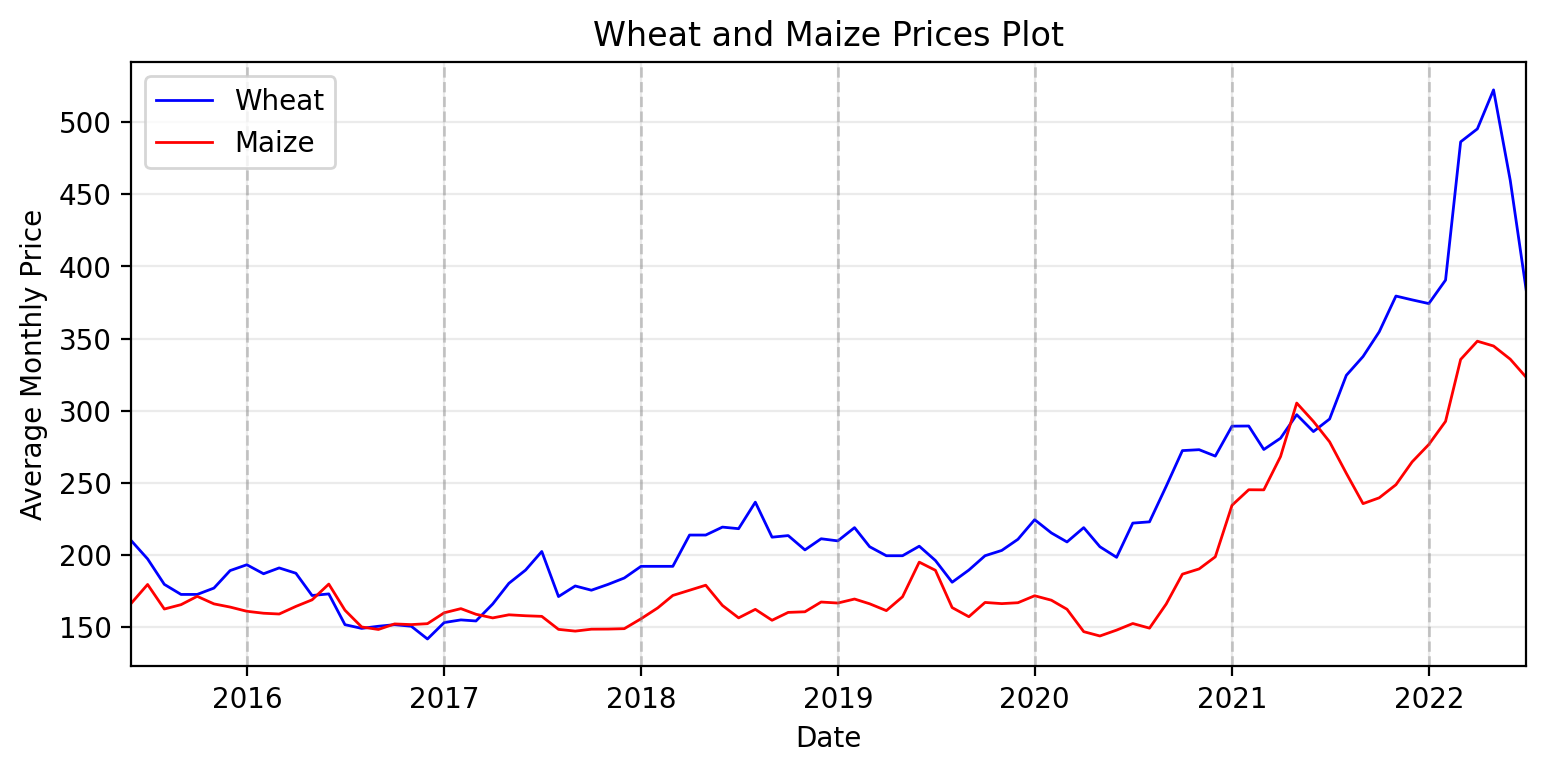

In [6]:
fig, ax = plt.subplots(figsize=(9,4), dpi=200)
ax.plot(df.index, df['Wheat'], c='blue', lw=1, label='Wheat')
ax.plot(df.index, df['Maize'], c='red', lw=1, label='Maize')
for year in range(min(df.index.year)+1,2023):
    ax.axvline(pd.to_datetime(str(year)+'-01-01'), c='gray', lw=1, ls='--', alpha=.4)
ax.grid(alpha=.25)
ax.legend()
ax.set_title('Wheat and Maize Prices Plot')
ax.set_ylabel('Average Monthly Price')
ax.set_xlabel('Date')
ax.margins(x=0)
plt.show()

<hr> </hr>

## Из графика Wheat очевидно, что данные нестационарны (в разных временных промежутках разное математическое ожидание). Таким образом, для построения модели временного ряда необходимо добиться стационарности ($\mu = const, \sigma^2 = const$, no seasonality).
<hr> </hr>

## Один из способов сделать это – взять для анализа не искомые данные, а разность первого порядка (F.O.D., first order difference).:

In [17]:
df_diff = df.diff(1).dropna()
df_diff.columns=['Wheat_diff','Maize_diff']

## Проведём расширенный тест Дики-Фуллера (ADF-test) для изначальных данных и данных F.O.D.:

In [8]:
adf_test(df['Wheat'])
adf_test(df['Maize'])

ADF-statistics: 1.1070
p-value: 0.9953
ADF-statistics: 0.3571
p-value: 0.9798


In [9]:
adf_test(df_diff['Wheat_diff'])
adf_test(df_diff['Maize_diff'])

ADF-statistics: -3.0267
p-value: 0.0325
ADF-statistics: -4.7082
p-value: 0.0001


## Данные стационарные по ADF-тесту (P-значения < 0.05).
## Чёткого сезонного паттерна в данных ни по Wheat, ни по Maize, не наблюдается, поэтому SARIMA(p,d,q)x(P,D,Q)S не подойдёт.
## Таким образом, будем работать с ARIMA(p,d,q), где $d > 0$ (отвечает за разность $d$-го порядка).

<hr> </hr>

## Были написаны функции `ARIMA_best`, `check_model_values` и `forecast` (см. выше в "Функции для исследования").
## – `ARIMA_best(series, maxorder)` – поиск наиболее оптимальной по критерию AIC модели ARIMA(p,d,q):
### series – анализируемый датафрейм;
### maxorder – максимальный порядок параметров p, d, q в модели;
### ДОП – выгружает в рабочую директорию .jpeg графики диагностики модели.
###
## `check_model_values(model, series)` – графическое изображение изначальных данных и смоделированных (fitted values):
## model – модель, полученная в прошлом шаге;
### series – анализируемый датафрейм.
### Функция также выводит MAPE (Mean Absolute Percent Error).
### ДОП – выгружает в рабочую директорию .jpeg график.
###
## `forecast(model, series, steps)` – построение прогноза и доверительного интервала ($\alpha = 0.05$):
### steps – количество месяцев, для которого будет строится прогноз по модели (default = 24, или же 2 года).
### ДОП – выгружает в рабочую директорию .jpeg график прогноза модели и также .xlsx файл с доверительными интервалами и predicted values.
###

## При помощи заданных функций были построены модели, основанные на данных за разные временные промежутки с 2010 по 2022 гг., с 2011 по 2022 гг., с 2013 по 2022 гг. и т.д.
## Таким образом, наиболее оптимальные модели (по AIC, с P-значениями < 0.05) для исследуемых показателей вышли следующие:
###
## WHEAT: модель ARIMA(2,1,2) вида
## $A_t = 1.0213 A_{t-1} - 0.8163 A_{t-2} - 0.7255 \varepsilon_{A,t-1} + 0.6407 \varepsilon_{A,t-2}$, где $A_t = w_t - w_{t-1}$ (разность первого порядка).
## Остатки модели распределены практически нормально ($\varepsilon \sim N(0,1)$), также между ними отсутствует автокорреляция, то есть остатки напоминают белый шум.

                               SARIMAX Results                                
Dep. Variable:                  Wheat   No. Observations:                   86
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -363.327
Date:                Fri, 16 Sep 2022   AIC                            736.654
Time:                        13:23:54   BIC                            748.867
Sample:                    06-01-2015   HQIC                           741.566
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3723      0.118      3.155      0.002       0.141       0.604
ar.L2         -0.6902      0.155     -4.467      0.000      -0.993      -0.387
ma.L1         -0.1701      0.089     -1.922      0.0

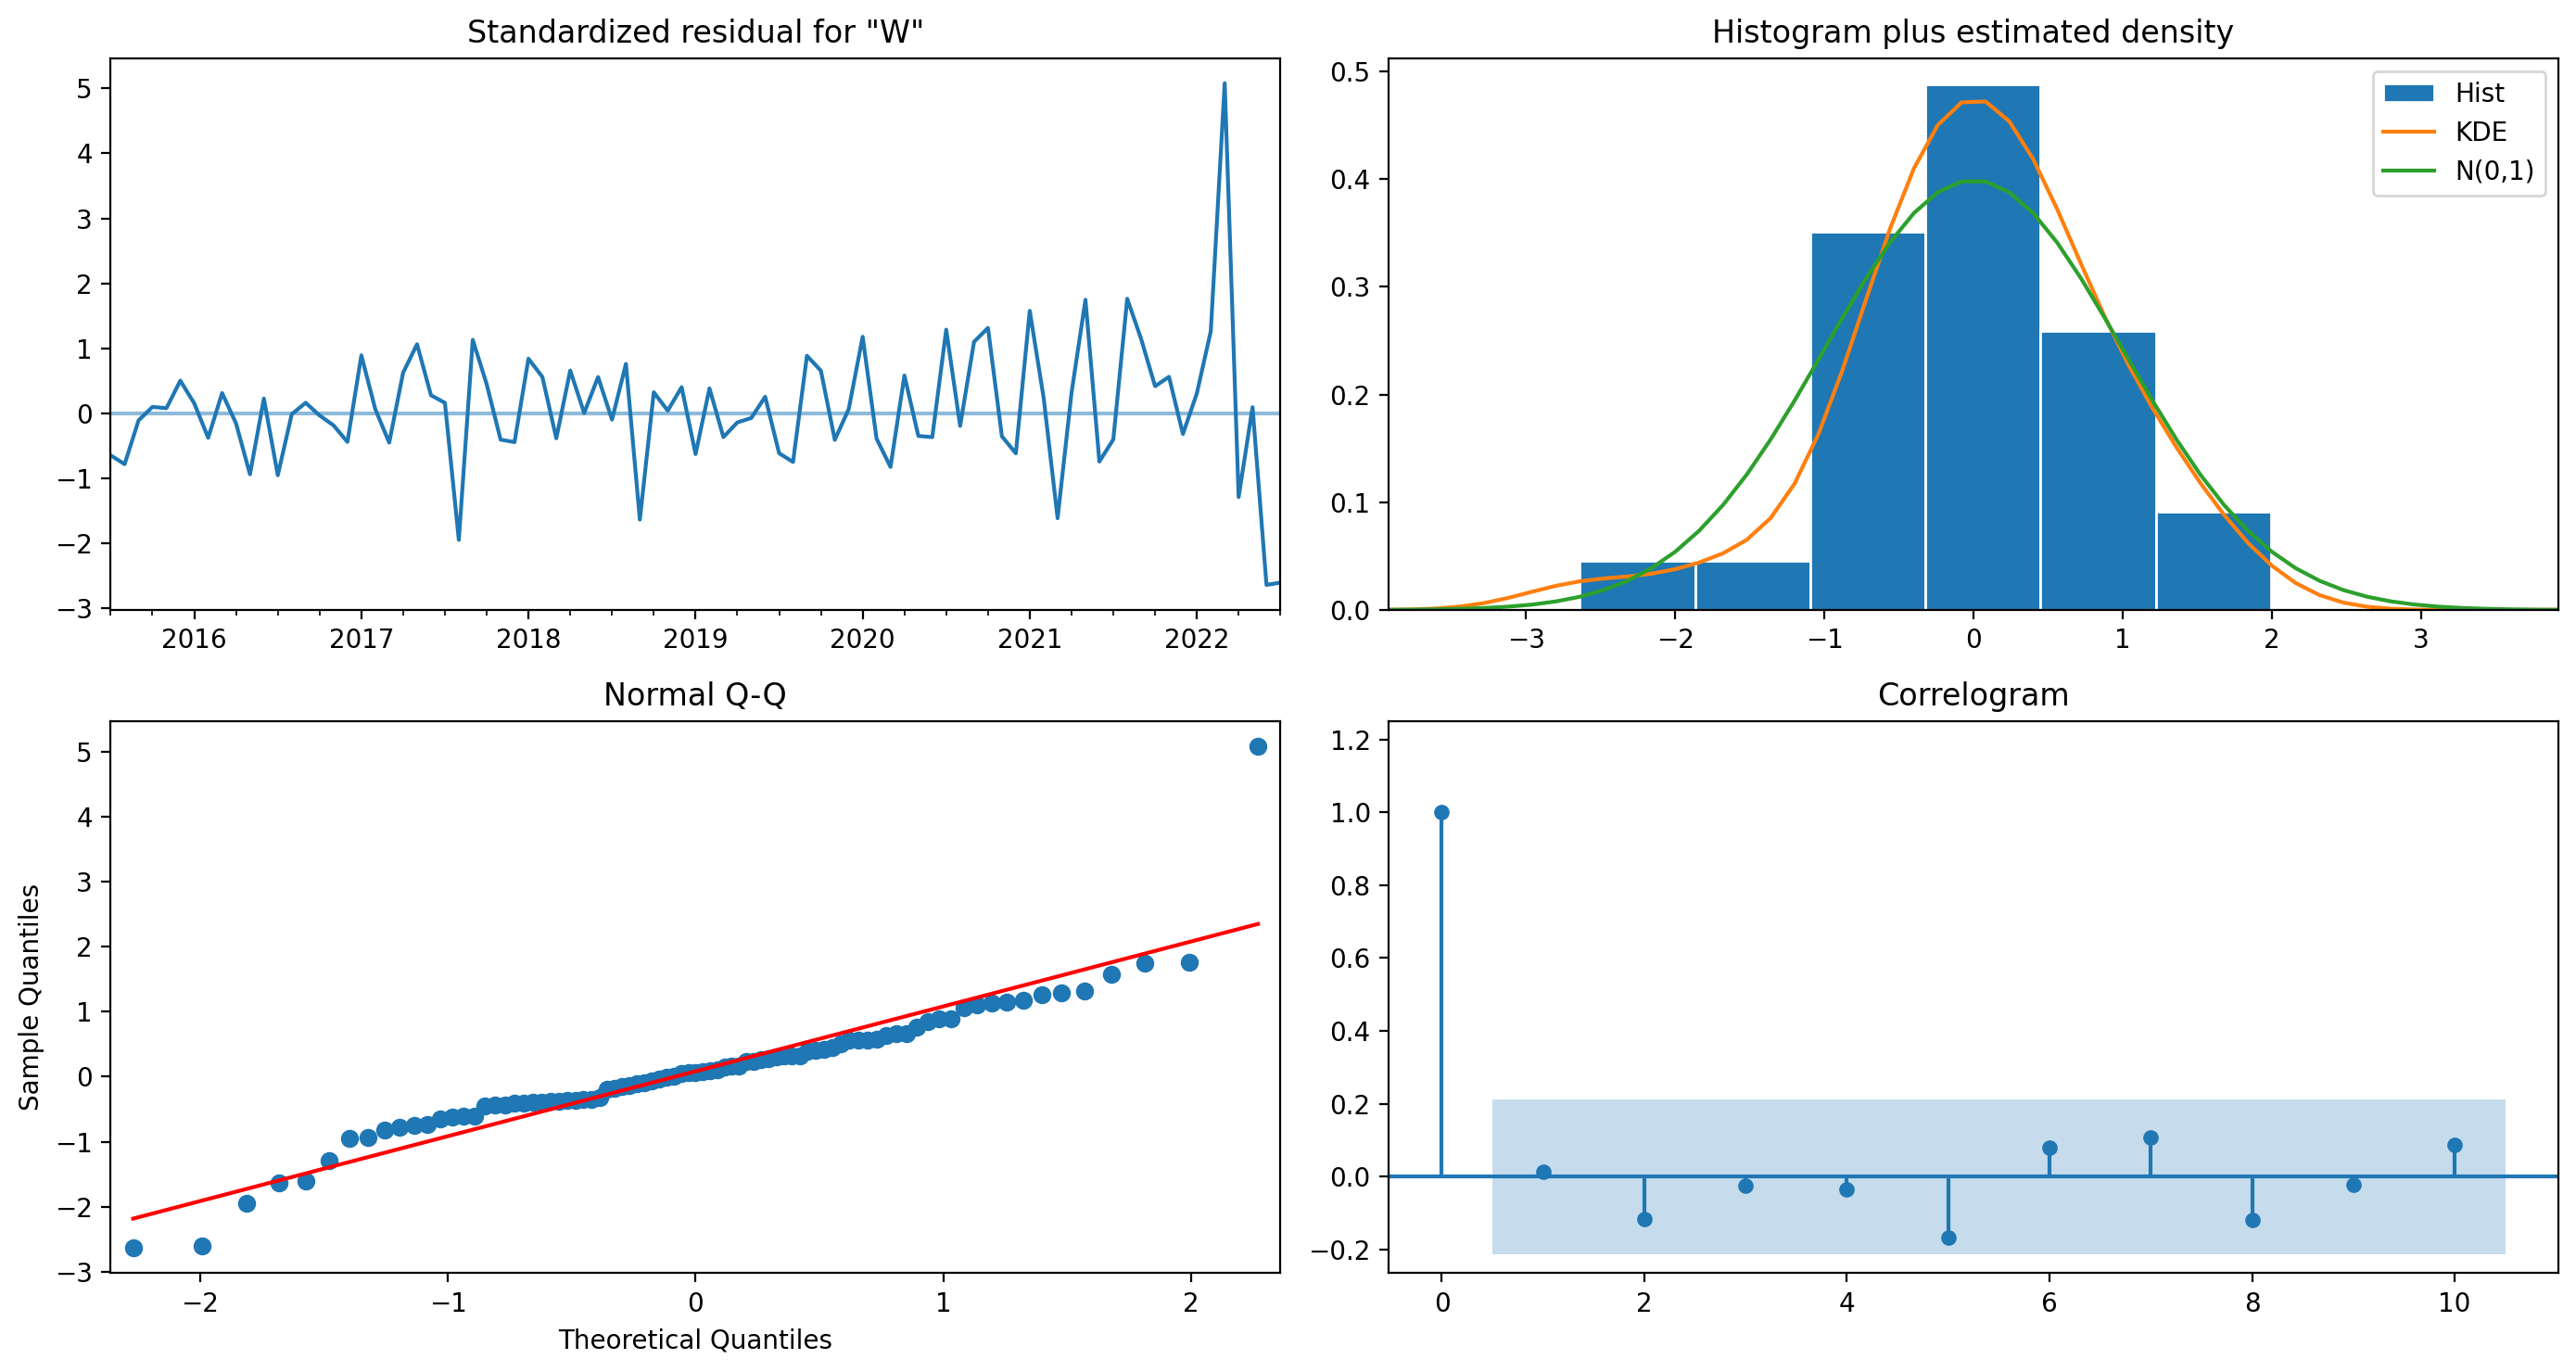

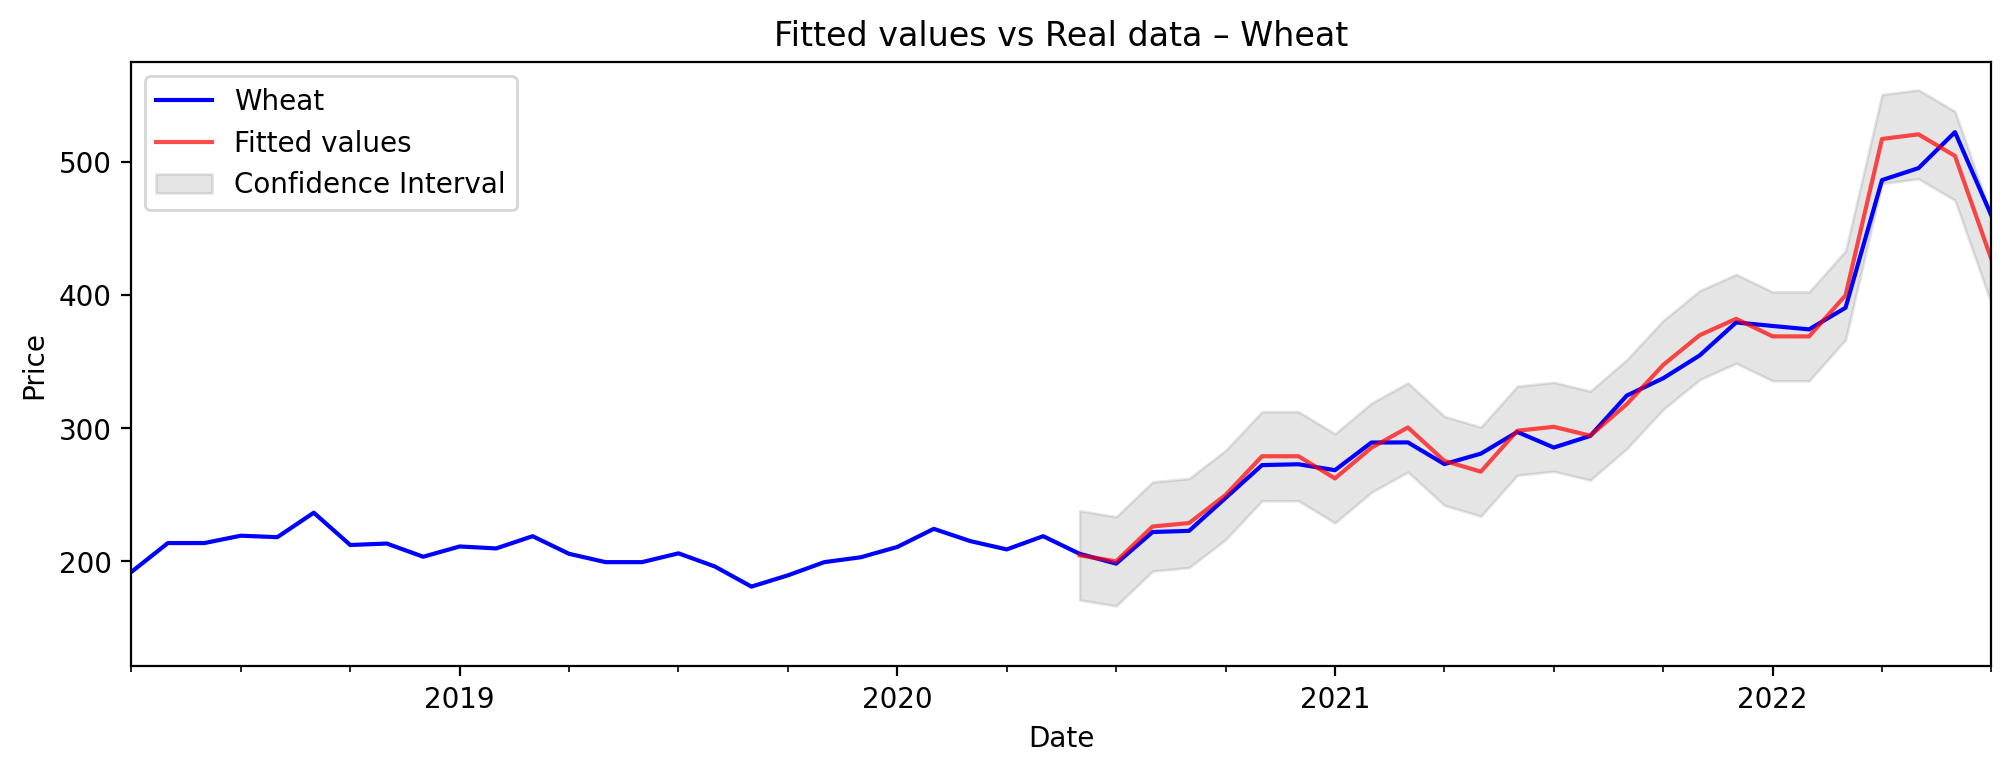

Mean Absolute Percent Error: 5.9964 %
     That is ± good (> 5% and < 15%)
Root Mean Squared Error: 28.34101


In [10]:
model_wheat = ARIMA_best(df.Wheat, check='AIC', maxorder=3)
check_model_values(model_wheat, df.Wheat)

## MAIZE: модель ARIMA(0,2,2) вида
## $B_t = -0.5171 B_{t-1} - 0.4577 B_{t-2}$, где $B_t = m_t - 2m_{t-1} + m_{t-2}$ (разность второго порядка).
## Остатки модели распределены практически нормально (но дисперсия, или же разброс относительно матожидания, ниже, чем у нормального), также между ними отсутствует автокорреляция, то есть остатки напоминают белый шум.

                               SARIMAX Results                                
Dep. Variable:                  Maize   No. Observations:                   86
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -320.893
Date:                Fri, 16 Sep 2022   AIC                            647.786
Time:                        13:23:55   BIC                            655.078
Sample:                    06-01-2015   HQIC                           650.717
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4852      0.127     -3.835      0.000      -0.733      -0.237
ma.L2         -0.5079      0.195     -2.599      0.009      -0.891      -0.125
sigma2       116.7424     20.385      5.727      0.0

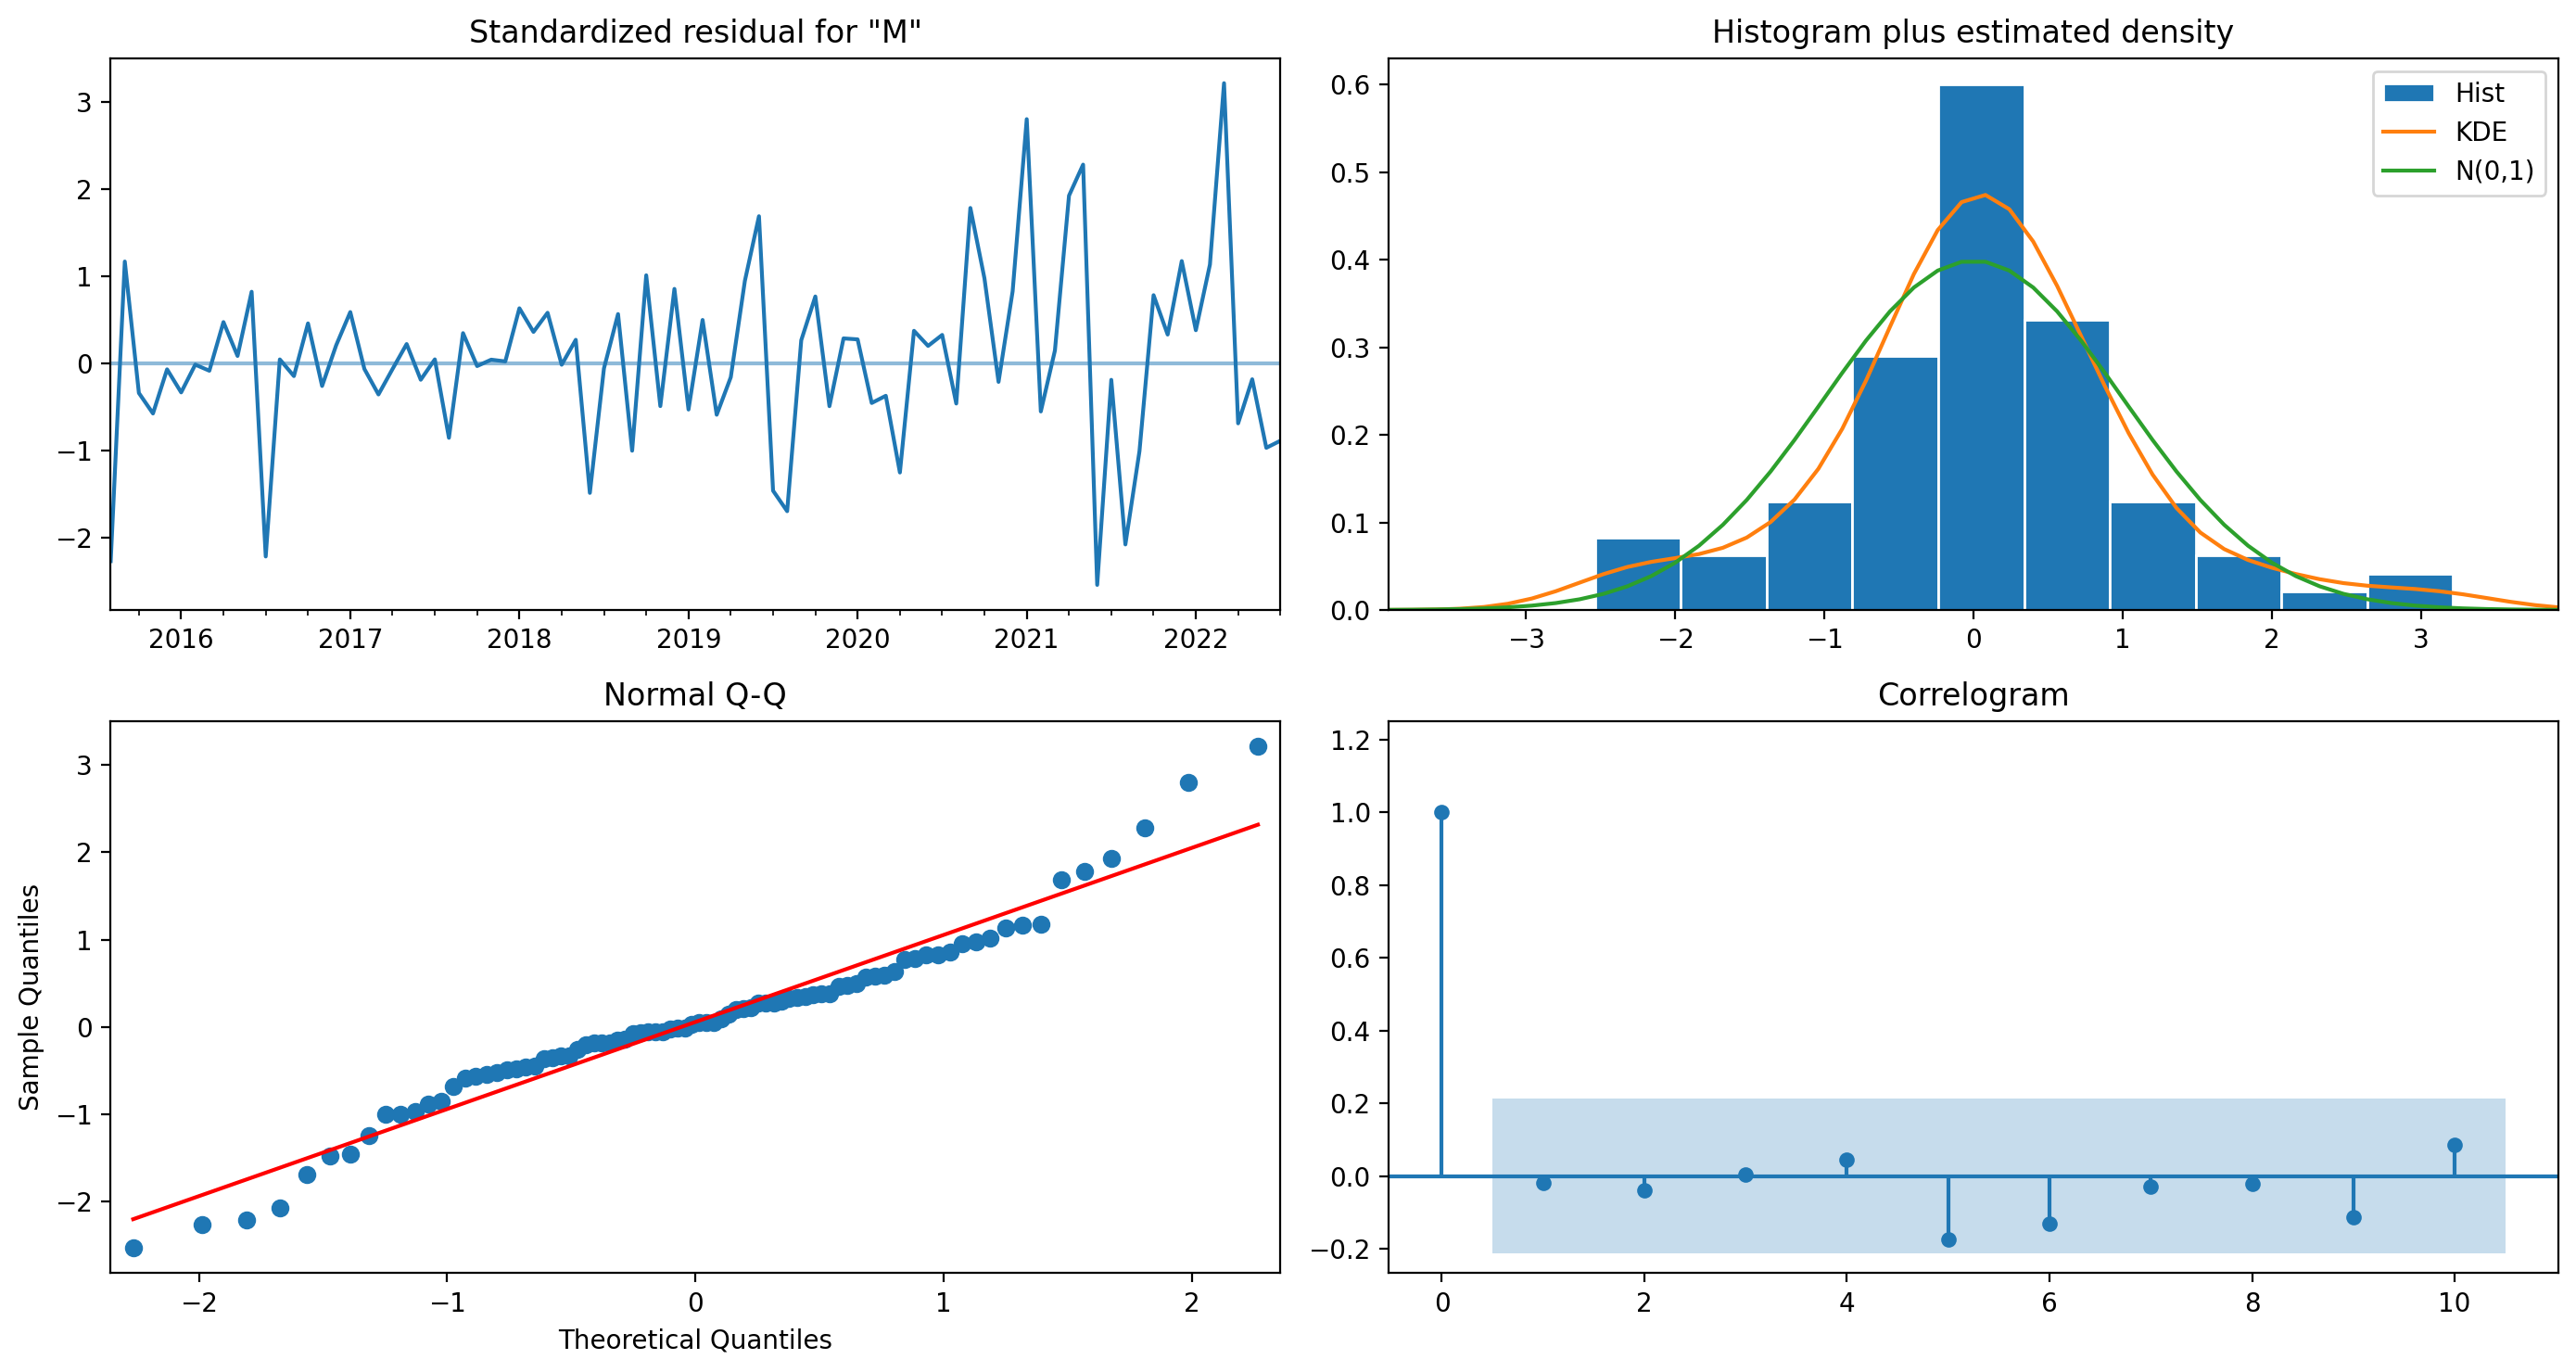

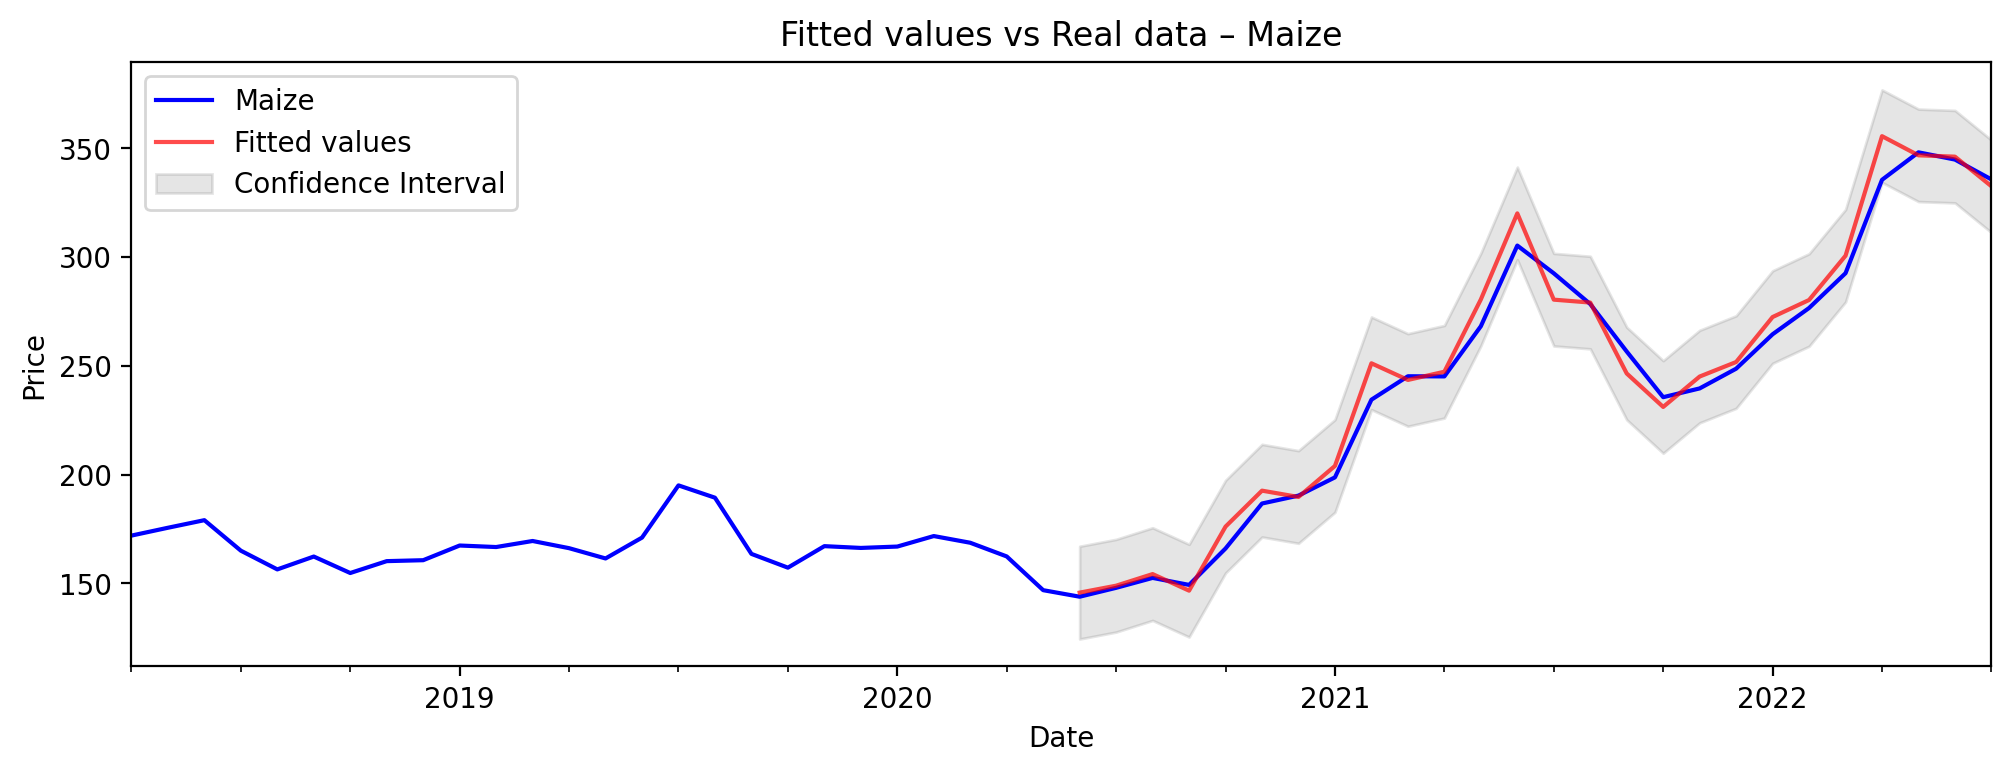

Mean Absolute Percent Error: 5.5472 %
     That is ± good (> 5% and < 15%)
Root Mean Squared Error: 22.38906


In [11]:
model_maize = ARIMA_best(df.Maize, check='AIC', maxorder=3)
check_model_values(model_maize, df.Maize)

# Прогнозирование:

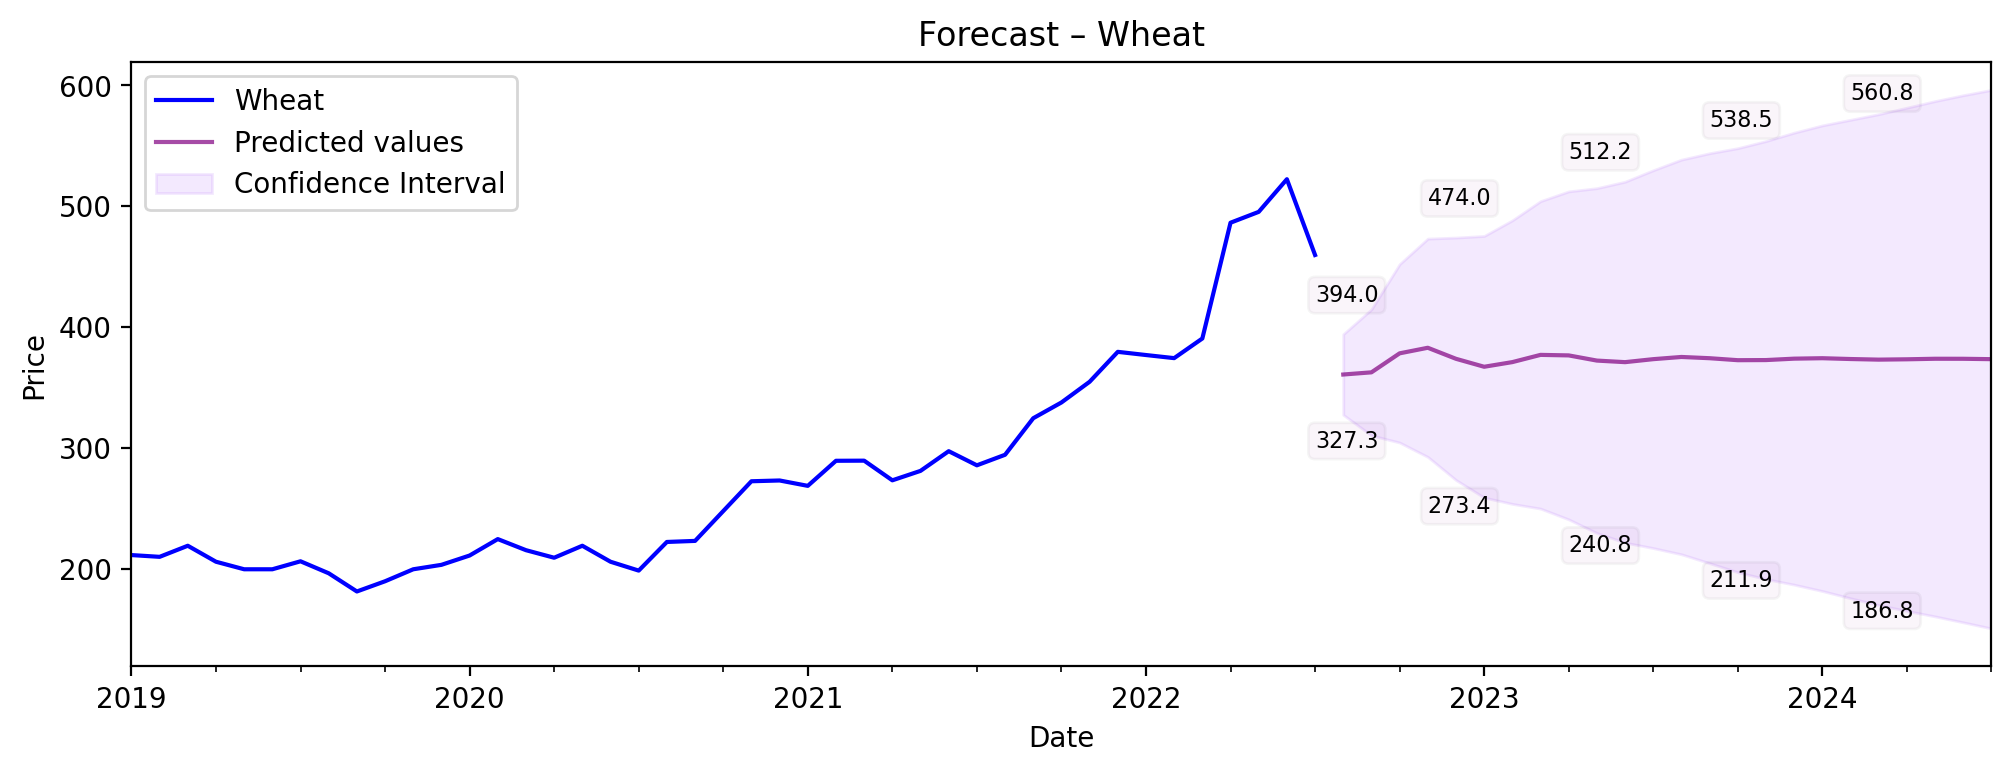

In [12]:
forecast(model_wheat, df.Wheat)

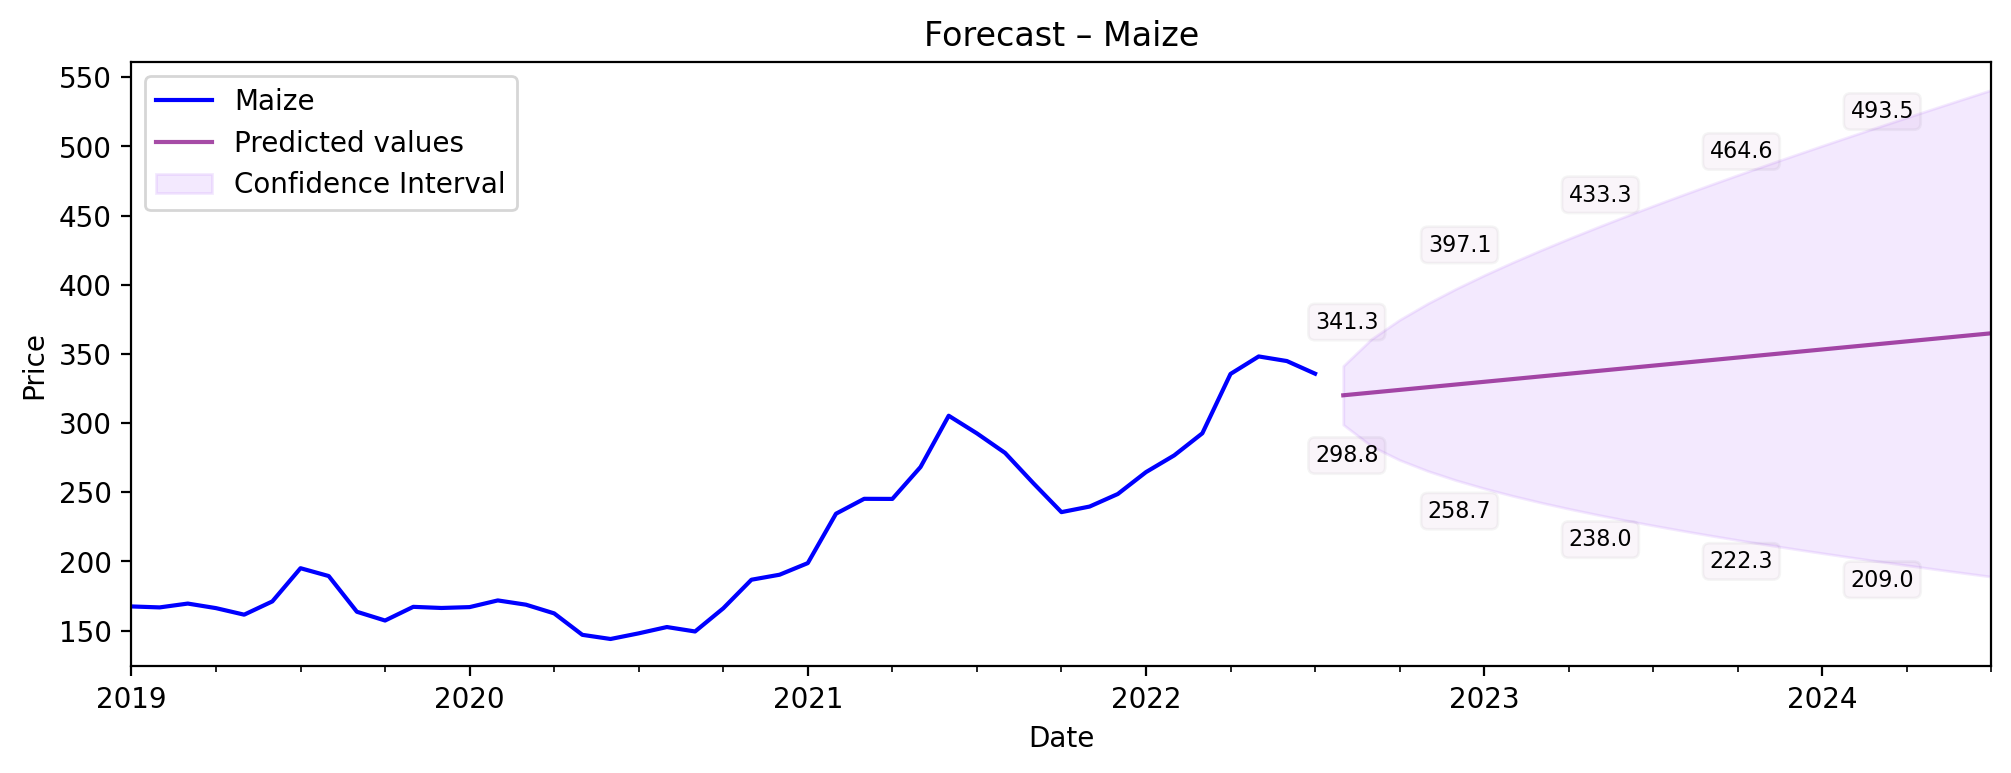

In [13]:
forecast(model_maize, df.Maize)

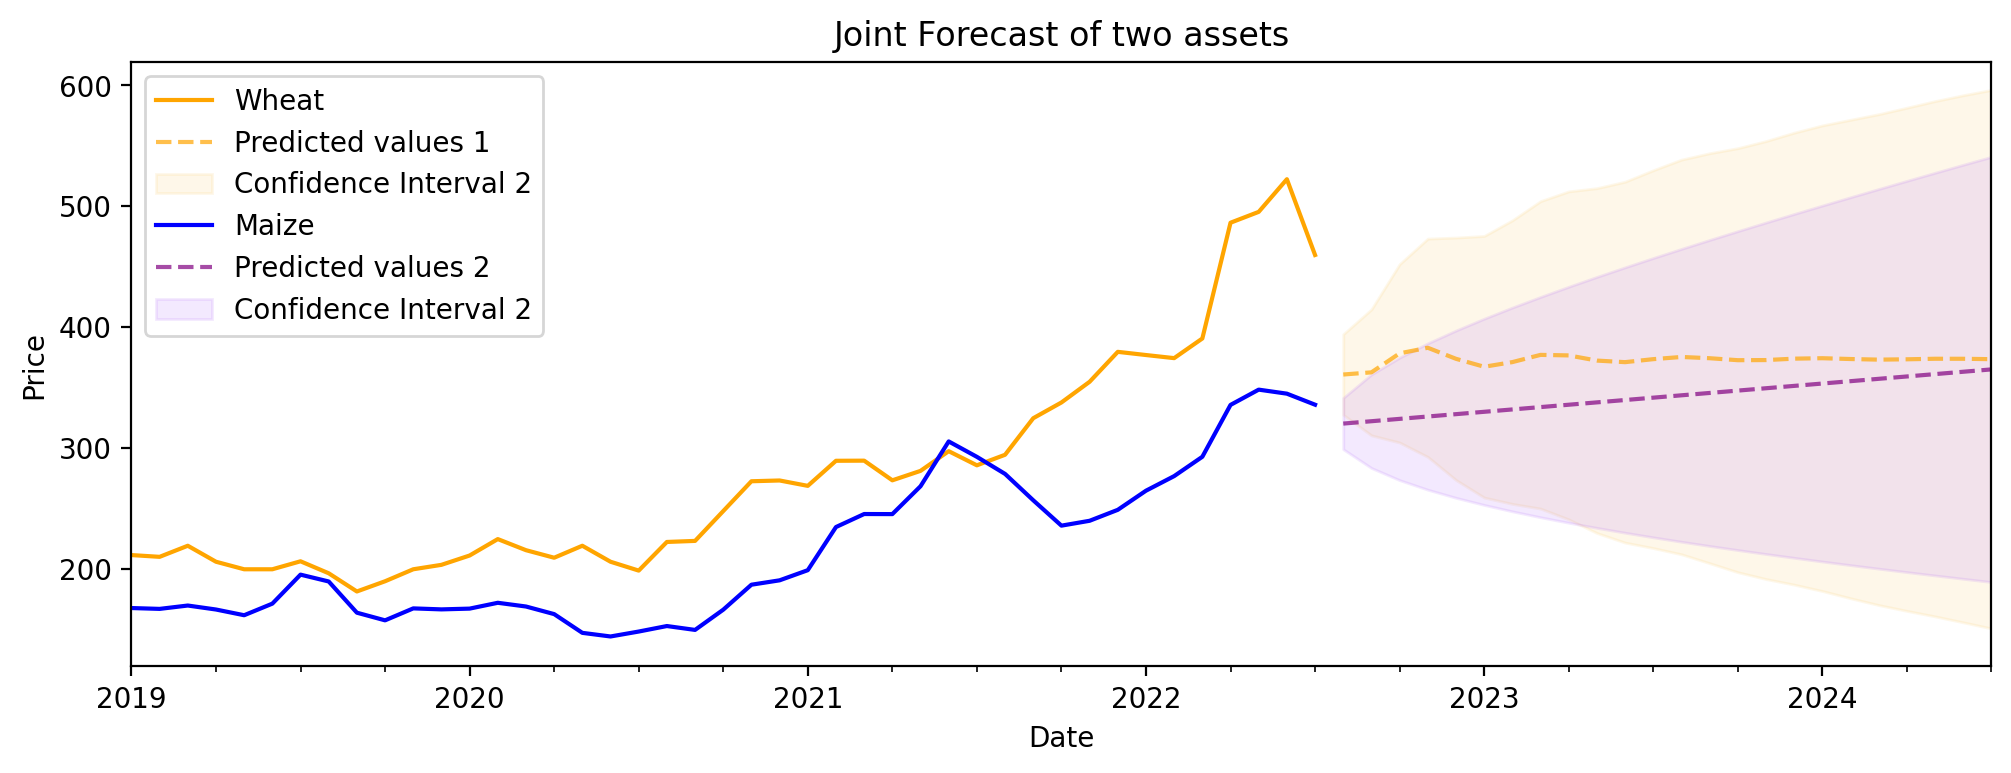

In [14]:
forecast_joint(model_wheat, model_maize, df.Wheat, df.Maize)

## Предсказывать подобного рода активы достаточно трудно, особенно на длинных временных промежутках. По этой причине наилучшим прогнозом здесь, по моему мнению, будет доверительный интервал (область, в которую с 95%-й вероятностью попадут значения). 
## Реальные цены на активы будут зависеть по большей части от глобальной макроэкономической и политической турбулентностью, поскольку во время всех мощных глобальных кризисов цены реагировали ростом. 
## В худшем для мировой экономики сценарии, предположительно, значения активов окажутся выше пунктирной черты и ниже верхней границы доверительного интервала; в лучшем же – ниже пунктирной черты.